TXTファイル数: 47
読み込み: population解凍\tblT001100S01.txt


C:\Users\moko0\AppData\Local\Temp\ipykernel_43984\2192183055.py:30: DtypeWarning: Columns (4,5,6,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(


読み込み: population解凍\tblT001100S02.txt
読み込み: population解凍\tblT001100S03.txt
読み込み: population解凍\tblT001100S04.txt
読み込み: population解凍\tblT001100S05.txt
読み込み: population解凍\tblT001100S06.txt
読み込み: population解凍\tblT001100S07.txt
読み込み: population解凍\tblT001100S08.txt
読み込み: population解凍\tblT001100S09.txt
読み込み: population解凍\tblT001100S10.txt
読み込み: population解凍\tblT001100S11.txt
読み込み: population解凍\tblT001100S12.txt
読み込み: population解凍\tblT001100S13.txt
読み込み: population解凍\tblT001100S14.txt
読み込み: population解凍\tblT001100S15.txt
読み込み: population解凍\tblT001100S16.txt
読み込み: population解凍\tblT001100S17.txt
読み込み: population解凍\tblT001100S18.txt
読み込み: population解凍\tblT001100S19.txt
読み込み: population解凍\tblT001100S20.txt
読み込み: population解凍\tblT001100S21.txt
読み込み: population解凍\tblT001100S22.txt
読み込み: population解凍\tblT001100S23.txt
読み込み: population解凍\tblT001100S24.txt
読み込み: population解凍\tblT001100S25.txt
読み込み: population解凍\tblT001100S26.txt
読み込み: population解凍\tblT001100S27.txt
読み込み: population解凍\tblT001100S28.txt
読

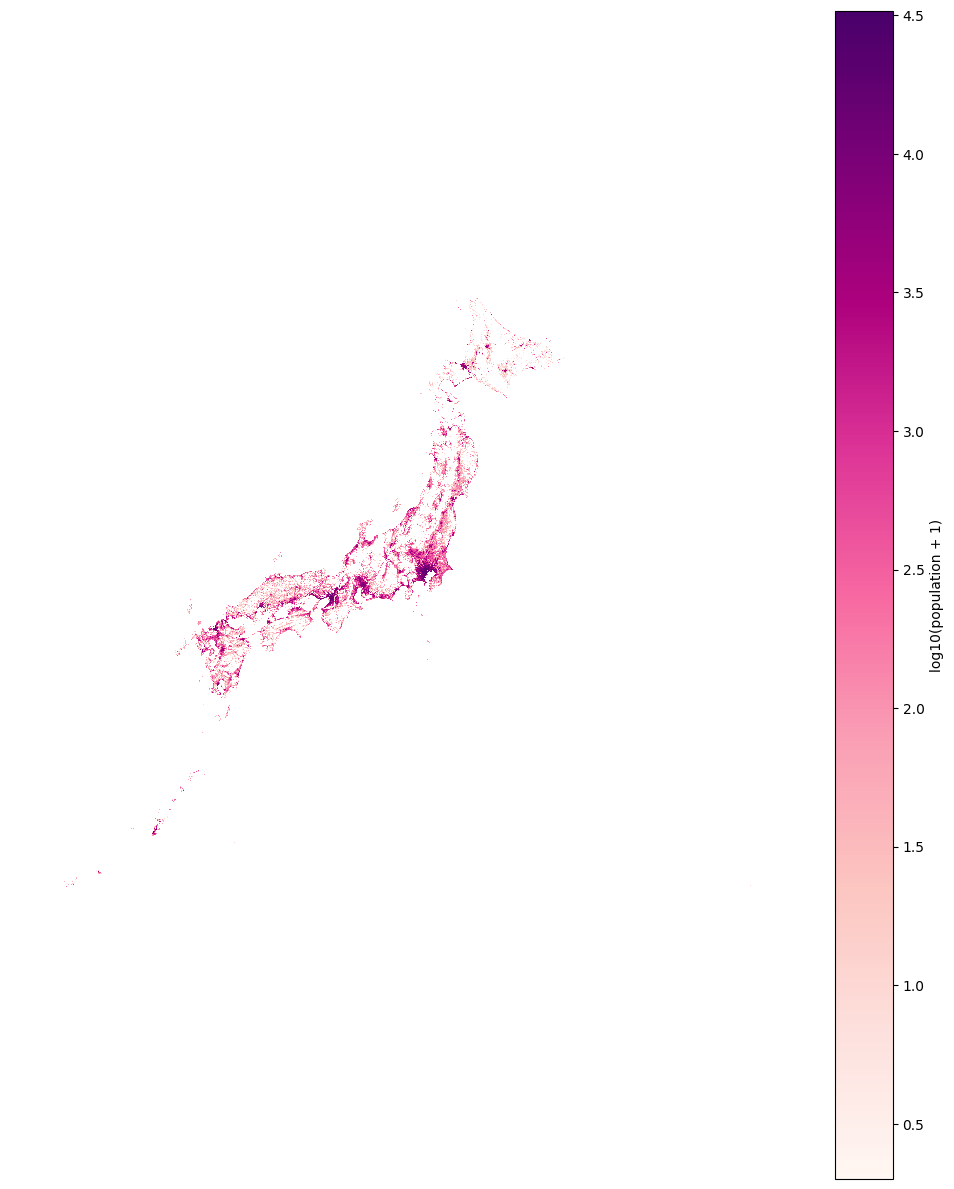

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ==============================
# 設定
# ==============================
MESH_TXT_DIR = "population解凍"   # 人口 TXT フォルダ
MESH_SHP_DIR = "地形-解凍"       # Shapefile フォルダ
OUTPUT_DIR   = "output"          # 出力フォルダ

os.makedirs(OUTPUT_DIR, exist_ok=True)


# ==============================
# 1. TXT（人口）をまとめる
# ==============================
def load_population():
    txt_files = glob.glob(os.path.join(MESH_TXT_DIR, "*.txt"))
    print("TXTファイル数:", len(txt_files))
    if not txt_files:
        raise FileNotFoundError("TXT が見つかりません。MESH_TXT_DIR を確認してください。")

    df_list = []
    for f in txt_files:
        print("読み込み:", f)
        temp = pd.read_csv(
            f,
            encoding="shift_jis",
            dtype={"KEY_CODE": str}
        )
        # 行0 は「人口（総数）」などの日本語ラベル行なので落とす
        temp = temp.iloc[1:].copy()

        # T001100001 = 総人口（* は NaN → 0）
        temp["T001100001"] = (
            pd.to_numeric(temp["T001100001"], errors="coerce")
              .fillna(0)
              .astype(int)
        )

        temp = temp[["KEY_CODE", "T001100001"]]
        df_list.append(temp)

    df_pop = pd.concat(df_list, ignore_index=True)
    df_pop = df_pop.rename(columns={
        "KEY_CODE": "meshcode",
        "T001100001": "population"
    })
    print("人口レコード数:", len(df_pop))
    return df_pop


# ==============================
# 2. Shapefile（メッシュポリゴン）をまとめる
# ==============================
def load_mesh_shapes():
    shp_files = glob.glob(os.path.join(MESH_SHP_DIR, "**", "*.shp"), recursive=True)
    print("Shapefile数:", len(shp_files))
    if not shp_files:
        raise FileNotFoundError("Shapefile が見つかりません。MESH_SHP_DIR を確認してください。")

    gdf_list = []
    for f in shp_files:
        print("Shapefile 読み込み:", f)
        gdf = gpd.read_file(f)
        gdf_list.append(gdf)

    gdf_all = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
    print("メッシュポリゴン数:", len(gdf_all))
    print("列名一覧:", gdf_all.columns.tolist())

    # メッシュコード列名を KEY_CODE と仮定（違う場合はここを書き換え）
    if "KEY_CODE" in gdf_all.columns:
        gdf_all = gdf_all.rename(columns={"KEY_CODE": "meshcode"})
    else:
        raise KeyError("Shapefile に KEY_CODE 列がありません。メッシュコード列名を確認して書き換えてください。")

    gdf_all["meshcode"] = gdf_all["meshcode"].astype(str)

    # 座標系を WGS84 に揃える
    if gdf_all.crs is None:
        gdf_all = gdf_all.set_crs("EPSG:4326")
    else:
        gdf_all = gdf_all.to_crs("EPSG:4326")

    return gdf_all


# ==============================
# 3. 結合してコロプレスを描く
# ==============================
def make_choropleth():
    df_pop = load_population()
    gdf_mesh = load_mesh_shapes()

    # population をメッシュポリゴンに join
    gdf = gdf_mesh.merge(df_pop, on="meshcode", how="inner")
    print("結合後レコード数:", len(gdf))

    # 人口ゼロのメッシュは描画しなくてもOKならここで落としてもよい
    # gdf = gdf[gdf["population"] > 0]

    # 見やすくするために log10 変換
    gdf["log_pop"] = np.log10(gdf["population"] + 1)

    # 描画
    fig, ax = plt.subplots(figsize=(10, 12))
    gdf.plot(
        column="log_pop",
        cmap="RdPu",          # ピンク〜紫
        linewidth=0,
        ax=ax,
        legend=True,
        legend_kwds={"label": "log10(population + 1)"}
    )

    ax.set_axis_off()
    plt.tight_layout()

    out_png = os.path.join(OUTPUT_DIR, "japan_population_choropleth.png")
    plt.savefig(out_png, dpi=300)
    print(f"✅ コロプレス画像を出力しました → {out_png}")


if __name__ == "__main__":
    make_choropleth()


In [6]:
import os
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. メッシュ中心点＋人口を読み込み
df = pd.read_csv(os.path.join(OUTPUT_DIR, "japan_population_1km.csv"))

# population が 0 の行は消してもOK（軽量化）
df = df[df["population"] > 0].copy()

# 2. 重さ（weight）を作る
#   そのままだと東京だけ真っ黒になるので、log＋正規化
df["weight"] = np.log1p(df["population"])
df["weight"] = df["weight"] / df["weight"].max()  # 0〜1 に正規化

# 3. さらに軽くしたい場合はサンプリング（全国なら推奨）
#    コメントアウトを外して調整してもOK
# df = df.sample(n=200000, random_state=42)  # 点が多すぎる時は20万点くらいに

# 4. 中心位置（日本の真ん中あたり）
center_lat = df["lat"].mean()
center_lon = df["lon"].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=5,
    tiles="CartoDB positron"   # 見やすい白ベース地図
)

# 5. HeatMap 用のデータ [lat, lon, weight]
heat_data = df[["lat", "lon", "weight"]].values.tolist()

HeatMap(
    heat_data,
    radius=8,         # ぼかしの広さ。重ければ 4〜6 に下げる
    blur=10,
    max_zoom=8,
).add_to(m)

out_html = os.path.join(OUTPUT_DIR, "japan_population_heatmap.html")
m.save(out_html)
print(f"✅ {out_html} を作成しました。ブラウザで開いてみてください。")


✅ output\japan_population_heatmap.html を作成しました。ブラウザで開いてみてください。


In [6]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

CSV_PATH = "SSDSE-B-2025.csv"
TARGET_YEAR = 2020

# -----------------------
# 1. データ読み込み
# -----------------------
df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

# -----------------------
# 2. 注目する3カテゴリ
# -----------------------
focus_cols = {
    "住居費（二人以上の世帯）": "住居費",
    "交通・通信費（二人以上の世帯）": "交通・通信費",
    "教育費（二人以上の世帯）": "教育費",
}

# -----------------------
# 3. 都市 vs 地方 に分類
# -----------------------
metro = ["東京都", "神奈川県", "千葉県", "埼玉県",
         "愛知県", "大阪府", "兵庫県", "福岡県"]

def classify(pref):
    return "都市" if pref in metro else "地方"

df_year["地域"] = df_year["都道府県"].map(classify)

# -----------------------
# 4. ロング型に変換
# -----------------------
df_long = df_year.melt(
    id_vars=["都道府県", "地域"],
    value_vars=list(focus_cols.keys()),
    var_name="カテゴリ",
    value_name="支出額"
)

df_long["カテゴリ"] = df_long["カテゴリ"].map(focus_cols)

# -----------------------
# 5. 地域別平均
# -----------------------
region_mean = (
    df_long
    .groupby(["地域", "カテゴリ"], as_index=False)["支出額"]
    .mean()
)

# 全国平均（参照用）
national_mean = (
    df_long
    .groupby("カテゴリ", as_index=False)["支出額"]
    .mean()
)

# -----------------------
# 6. 可視化（ハイライト設計）
# -----------------------
fig = go.Figure()

# 色設計
colors = {
    "都市": "#1f77b4",   # 濃く
    "地方": "#cccccc"    # グレー
}

for region in ["地方", "都市"]:  # 地方 → 都市の順で描画
    sub = region_mean[region_mean["地域"] == region]
    fig.add_trace(go.Bar(
        x=sub["支出額"],
        y=sub["カテゴリ"],
        orientation="h",
        name=region,
        marker_color=colors[region],
        opacity=1.0 if region == "都市" else 0.6
    ))

# 全国平均の参照線
for _, row in national_mean.iterrows():
    fig.add_vline(
        x=row["支出額"],
        line_width=1,
        line_dash="dot",
        line_color="black",
        opacity=0.4
    )

# -----------------------
# 7. レイアウト調整
# -----------------------
fig.update_layout(
    title=f"{TARGET_YEAR}年 都市と地方の生活コスト構造の違い（住居・交通・教育）",
    barmode="group",
    xaxis_title="月あたり支出額（円）",
    yaxis_title="",
    legend_title="地方",
    width=900,
    height=450,
    margin=dict(l=80, r=40, t=70, b=40),
)

fig.show()


In [31]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

CSV_PATH = "SSDSE-B-2025.csv"
TARGET_YEAR = 2020

df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

# ---- 10カテゴリ ----
spend_cols = [
    
    "住居費（二人以上の世帯）",
    "光熱・水道費（二人以上の世帯）",
    "家具・家事用品費（二人以上の世帯）",
    "被服及び履物費（二人以上の世帯）",
    "保健医療費（二人以上の世帯）",
    "教育費（二人以上の世帯）",
    "教養娯楽費（二人以上の世帯）",
    
]

metro = [
    "東京都", "神奈川県", "葉県", "埼玉県",
    "愛知県", "大阪府", "兵庫県", "福岡県"
]

# 各県の平均
pref_means = (
    df_year
    .groupby("都道府県", as_index=False)[spend_cols]
    .mean()
)

# 全国平均
nat_mean = pref_means[spend_cols].mean()

# 大都市圏平均
metro_mean = pref_means[pref_means["都道府県"].isin(metro)][spend_cols].mean()

# スロープチャート用データ
df_slope = pd.DataFrame({
    "カテゴリ": spend_cols * 2,
    "系列": (["全国平均"] * len(spend_cols)) + (["大都市圏平均"] * len(spend_cols)),
    "金額": list(nat_mean.values) + list(metro_mean.values),
})

df_slope["金額_千円"] = (df_slope["金額"] / 1000).round(1)

# カテゴリを全国平均の高い順に並べる
cat_order = (
    df_slope[df_slope["系列"] == "全国平均"]
    .sort_values("金額_千円", ascending=False)["カテゴリ"]
    .tolist()
)

fig = px.line(
    df_slope,
    x="系列",
    y="金額_千円",
    color="カテゴリ",
    line_group="カテゴリ",
    markers=True,
    category_orders={
        "系列": ["全国平均", "大都市圏平均"],
        "カテゴリ": cat_order
    },
    title=f"{TARGET_YEAR}年 全国平均 vs 大都市圏平均の支出構造差（7カテゴリ）",
    labels={"金額_千円": "月あたり支出額（千円）"}
)

# ホバー情報
fig.update_traces(
    hovertemplate="%{x}<br>%{legendgroup}<br>%{y:.1f} 千円"
)

fig.update_yaxes(showgrid=True, gridcolor="lightgray", dtick=5)

fig.update_layout(
    width=1000,
    height=650,
    legend_title="支出カテゴリ",
    margin=dict(l=80, r=80, t=80, b=40),
)

fig.show()


In [32]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

CSV_PATH = "SSDSE-B-2025.csv"
TARGET_YEAR = 2020

df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

# ---- 10カテゴリ ----
spend_cols = [
    "食料費（二人以上の世帯）",
    "交通・通信費（二人以上の世帯）",
    "その他の消費支出（二人以上の世帯）",
]

metro = [
    "東京都", "神奈川県", "千葉県", "埼玉県",
    "愛知県", "大阪府", "兵庫県", "福岡県"
]

# 各県の平均
pref_means = (
    df_year
    .groupby("都道府県", as_index=False)[spend_cols]
    .mean()
)

# 全国平均
nat_mean = pref_means[spend_cols].mean()

# 大都市圏平均
metro_mean = pref_means[pref_means["都道府県"].isin(metro)][spend_cols].mean()

# スロープチャート用データ
df_slope = pd.DataFrame({
    "カテゴリ": spend_cols * 2,
    "系列": (["全国平均"] * len(spend_cols)) + (["大都市圏平均"] * len(spend_cols)),
    "金額": list(nat_mean.values) + list(metro_mean.values),
})

df_slope["金額_千円"] = (df_slope["金額"] / 1000).round(1)

# カテゴリを全国平均の高い順に並べる
cat_order = (
    df_slope[df_slope["系列"] == "全国平均"]
    .sort_values("金額_千円", ascending=False)["カテゴリ"]
    .tolist()
)

fig = px.line(
    df_slope,
    x="系列",
    y="金額_千円",
    color="カテゴリ",
    line_group="カテゴリ",
    markers=True,
    category_orders={
        "系列": ["全国平均", "大都市圏平均"],
        "カテゴリ": cat_order
    },
    title=f"{TARGET_YEAR}年 全国平均 vs 大都市圏平均の支出構造差（3カテゴリ）",
    labels={"金額_千円": "月あたり支出額（千円）"}
)

# ホバー情報
fig.update_traces(
    hovertemplate="%{x}<br>%{legendgroup}<br>%{y:.1f} 千円"
)

fig.update_yaxes(showgrid=True, gridcolor="lightgray", dtick=5)

fig.update_layout(
    width=1000,
    height=650,
    legend_title="支出カテゴリ",
    margin=dict(l=80, r=80, t=80, b=40),
)

fig.show()


In [7]:
import pandas as pd
import plotly.express as px

CSV_PATH = "SSDSE-B-2025.csv"
AREA_CSV = "pref_area.csv"
TARGET_YEAR = 2020

# -----------------------
# 1. データ読み込み
# -----------------------
df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

# -----------------------
# 2. 人口密度を計算
# -----------------------
pop_df = df_year.groupby("都道府県", as_index=False)[["総人口"]].mean()
area_df = pd.read_csv(AREA_CSV)  # 列: 都道府県, 面積_km2

pop_area = pop_df.merge(area_df, on="都道府県", how="inner")
pop_area["人口密度"] = pop_area["総人口"] / pop_area["面積_km2"]

# -----------------------
# 3. 注目する3カテゴリ
# -----------------------
focus_cols = [
    "住居費（二人以上の世帯）",
    "教育費（二人以上の世帯）",
    "交通・通信費（二人以上の世帯）",
]

# -----------------------
# 4. 都道府県ごとの支出平均
# -----------------------
pref_means = df_year.groupby("都道府県", as_index=False)[focus_cols].mean()

# -----------------------
# 5. 支出 + 人口密度を結合
# -----------------------
df_merged = pref_means.merge(pop_area, on="都道府県", how="inner")

# -----------------------
# 6. 都市 vs 地方 に分類
# -----------------------
metro = [
    "東京都","神奈川県","千葉県","埼玉県",
    "愛知県","大阪府","兵庫県","福岡県"
]

def classify_region(pref):
    return "都市" if pref in metro else "地方"

df_merged["地域"] = df_merged["都道府県"].map(classify_region)

# -----------------------
# 7. ロング型に変換
# -----------------------
df_long = df_merged.melt(
    id_vars=["都道府県", "人口密度", "地域"],
    value_vars=focus_cols,
    var_name="カテゴリ",
    value_name="支出額"
)

df_long["支出額_千円"] = df_long["支出額"] / 1000

# -----------------------
# 8. 散布図（人口密度 × 支出）
# -----------------------
fig = px.scatter(
    df_long,
    x="人口密度",
    y="支出額_千円",
    color="地域",
    facet_col="カテゴリ",
    trendline="ols",
    hover_name="都道府県",
    color_discrete_map={
        "都市": "#1f77b4",   # 濃く
        "地方": "#cccccc"    # グレー
    },
    labels={
        "人口密度": "人口密度（人/km²）",
        "支出額_千円": "月あたり支出額（千円）",
        "カテゴリ": "支出カテゴリ",
        "地域": "地域"
    },
    title=f"{TARGET_YEAR}年 人口密度と生活コストの関係（都市 vs 地方）"
)

# x軸をログスケール（全facetに適用）
for axis in fig.layout:
    if axis.startswith("xaxis"):
        fig.layout[axis].type = "log"

# -----------------------
# 9. レイアウト調整
# -----------------------
fig.update_layout(
    width=1100,
    height=450,
    margin=dict(l=60, r=20, t=80, b=40),
    legend_title="地域"
)

fig.show()
fig.write_html("panel_population_density_urban_vs_rural.html")


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.io as pio

CSV_PATH = "SSDSE-B-2025.csv"
TARGET_YEAR = 2020

df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

# 支出カテゴリ
spend_cols = [
    "食料費（二人以上の世帯）",
    "住居費（二人以上の世帯）",
    "光熱・水道費（二人以上の世帯）",
    "家具・家事用品費（二人以上の世帯）",
    "被服及び履物費（二人以上の世帯）",
    "保健医療費（二人以上の世帯）",
    "交通・通信費（二人以上の世帯）",
    "教育費（二人以上の世帯）",
    "教養娯楽費（二人以上の世帯）",
    "その他の消費支出（二人以上の世帯）"
]

# 合計支出
df_year["総支出"] = df_year[spend_cols].sum(axis=1)

# 重要：比率特徴量を追加（これで地方中核を明確にする）
df_year["交通比率"] = df_year["交通・通信費（二人以上の世帯）"] / df_year["総支出"]
df_year["住居比率"] = df_year["住居費（二人以上の世帯）"] / df_year["総支出"]
df_year["教育比率"] = df_year["教育費（二人以上の世帯）"] / df_year["総支出"]

# K-means 用データ
X = df_year[spend_cols + ["交通比率", "住居比率", "教育比率"]]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means（3クラス）
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_year["クラスタ"] = labels

# クラスタ中心の元スケール値
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns)

# クラス名を自動で付ける
class_names = {}
for idx, row in centers_df.iterrows():
    if row["住居費（二人以上の世帯）"] == centers_df["住居費（二人以上の世帯）"].max():
        class_names[idx] = "都市型（家賃中心）"
    elif row["交通比率"] == centers_df["交通比率"].max():
        class_names[idx] = "地方中核（車社会）"
    else:
        class_names[idx] = "低密度（低コスト）"

df_year["生活コストモデル"] = df_year["クラスタ"].map(class_names)

# クラスごとの平均
plot_df = df_year.groupby("生活コストモデル")[spend_cols].mean().reset_index()

# ロング化
df_long = plot_df.melt(id_vars="生活コストモデル", var_name="カテゴリ", value_name="支出額")

fig = px.bar(
    df_long,
    x="カテゴリ",
    y="支出額",
    color="生活コストモデル",
    barmode="group",
    title="2020年 支出構造の3クラス（都市型・車社会型・低密度型）",
    labels={"支出額": "月あたり支出額（円）", "カテゴリ": "支出カテゴリ"}
)

fig.update_layout(xaxis_tickangle=40)
fig.show()



c:\Users\moko0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [7]:
import os
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# === 1. あなたのクラスタ結果 ===
pref_cluster = (
    df_year
    .groupby("都道府県")["生活コストモデル"]
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

# === 2. shapefile をフォルダから自動で取得 ===
SHAPE_DIR = "地形-解凍"  # ←自分のフォルダ名に変更
shp_path = glob.glob(os.path.join(SHAPE_DIR, "*.shp"))[0]

gdf_pref = gpd.read_file(shp_path)

# ※ 都道府県名の列が何か確認して以下を変更
gdf_pref = gdf_pref.rename(columns={"pref_name": "都道府県"})  

# === 3. クラスタ結果を結合 ===
gdf_merged = gdf_pref.merge(pref_cluster, on="都道府県", how="left")

# === 4. 地図描画 ===
fig, ax = plt.subplots(figsize=(8, 10))

gdf_merged.plot(
    column="生活コストモデル",
    categorical=True,
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("2020年 支出構造の3クラス（都市型・車社会型・低密度型）", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("panel8_map_clusters.png", dpi=300)
plt.show()


KeyError: '都道府県'

In [12]:
!pip install jupyter-dash


In [13]:
import pandas as pd
import plotly.express as px

# =====================
# 設定
# =====================
CSV_PATH = "SSDSE-B-2025.csv"
TARGET_YEAR = 2020

COLOR_URBAN = "#1f77b4"   # 都市（主役）
COLOR_RURAL = "#cccccc" # 地方（比較）


# =====================
# データ読み込み
# =====================
df = pd.read_csv(CSV_PATH)
df_year = df[df["年度"] == TARGET_YEAR].copy()

focus_cols = [
    "住居費（二人以上の世帯）",
    "交通・通信費（二人以上の世帯）",
    "教育費（二人以上の世帯）",
]

df_pref = (
    df_year.groupby("都道府県", as_index=False)[focus_cols]
           .mean()
)

# 比較する2地域
pref_urban = "東京都"
pref_rural = "秋田県"

df_sel = df_pref[df_pref["都道府県"].isin([pref_urban, pref_rural])]

df_long = df_sel.melt(
    id_vars="都道府県",
    value_vars=focus_cols,
    var_name="カテゴリ",
    value_name="支出額"
)

# =====================
# 可視化
# =====================
fig = px.bar(
    df_long,
    x="カテゴリ",
    y="支出額",
    color="都道府県",
    barmode="group",
    color_discrete_map={
        pref_urban: COLOR_URBAN,
        pref_rural: COLOR_RURAL
    },
    title="都市と地方の生活装備の違い（東京都 vs 秋田県）"
)

# 不要な情報を抑える
fig.update_traces(
    selector=dict(name=pref_rural),
    marker=dict(opacity=0.4)
)

fig.update_layout(
    yaxis_title="月あたり支出額（円）",
    xaxis_title="",
    legend_title="",
    width=900,
    height=500,
    plot_bgcolor="white",
)

fig.show()

# =====================
# HTML 出力
# =====================
fig.write_html(
    "panel6_tokyo_vs_akita.html",
    include_plotlyjs="cdn"
)


In [18]:
import plotly.graph_objects as go

fig = go.Figure()

# =====================
# ボックス（矩形）
# =====================
def add_box(x0, y0, x1, y1, color):
    fig.add_shape(
        type="rect",
        x0=x0, y0=y0, x1=x1, y1=y1,
        line=dict(color=color, width=2),
        fillcolor=color,
        opacity=0.15
    )

# 左：人口密度
add_box(0.0, 0.55, 0.25, 0.85, "#2563eb")  # 都市
add_box(0.0, 0.15, 0.25, 0.45, "#9ca3af")  # 地方

# 中：生活装備
add_box(0.38, 0.55, 0.63, 0.85, "#2563eb")
add_box(0.38, 0.15, 0.63, 0.45, "#9ca3af")

# 右：支出
add_box(0.75, 0.55, 1.0, 0.85, "#2563eb")
add_box(0.75, 0.15, 1.0, 0.45, "#9ca3af")

# =====================
# 矢印
# =====================
def add_arrow(x0, y0, x1, y1):
    fig.add_annotation(
        x=x1, y=y1,
        ax=x0, ay=y0,
        arrowhead=3,
        arrowsize=1.2,
        arrowwidth=2,
        arrowcolor="black",
        showarrow=True
    )

add_arrow(0.25, 0.7, 0.38, 0.7)
add_arrow(0.25, 0.3, 0.38, 0.3)
add_arrow(0.63, 0.7, 0.75, 0.7)
add_arrow(0.63, 0.3, 0.75, 0.3)

# =====================
# テキスト
# =====================
annotations = [
    # 人口密度
    (0.125, 0.78, "人口密度：高"),
    (0.125, 0.38, "人口密度：低"),

    # 生活装備
    (0.505, 0.78, "公共交通\n住宅\n教育施設"),
    (0.505, 0.38, "自家用車\n戸建住宅"),

    # 支出
    (0.875, 0.78, "住居費 ↑\n教育費 ↑"),
    (0.875, 0.38, "交通・通信費 ↑"),
]

for x, y, text in annotations:
    fig.add_annotation(
        x=x, y=y,
        text=text,
        showarrow=False,
        font=dict(size=13),
        align="center"
    )

# =====================
# レイアウト
# =====================
fig.update_layout(
    title="人口密度が、生活装備を決め、支出構造を決める",
    width=900,
    height=450,
    xaxis=dict(visible=False, range=[0, 1]),
    yaxis=dict(visible=False, range=[0, 1]),
    plot_bgcolor="white"
)

fig.show()
fig.write_html("panel7_population_to_spending.html", include_plotlyjs="cdn")
